In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')

In [2]:
files_webshell = os.listdir("data/black_list/")
files_common = os.listdir("data/white_list/")

labels_webshell = []
labels_common = []
for i in range(0,len(files_webshell)):
    labels_webshell.append(1)
for i in range(0,len(files_common)):
    labels_common.append(0)

In [3]:
for i in range(0,len(files_webshell)):
    files_webshell[i] = "data/black_list/" + files_webshell[i]
   # files_webshell[i] = files_webshell[i]
for i in range(0,len(files_common)):
    files_common[i] = "data/white_list/" + files_common[i]

files = files_webshell + files_common
labels = labels_webshell + labels_common
datadict = {'label':labels,'file':files}
df = pd.DataFrame(datadict,columns=['label','file'])

In [4]:
df.tail()

,label,file
6244,0,white_list/WebUISharingContext.php
6245,0,white_list/WebUIUserContext.php
6246,0,white_list/welcome.html.php
6247,0,white_list/WelcomeShell.php
6248,0,white_list/zu_za.php


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6249 entries, 0 to 6248
Data columns (total 2 columns):
label    6249 non-null int64
file     6249 non-null object
dtypes: int64(1), object(1)
memory usage: 97.7+ KB


In [6]:
#文件长度特征
def getfilelen(x):
    length = 0
    with open(x,'r',encoding='ISO-8859-1') as f:
        content = f.readlines()
        for i in content:
            length = length + len(i)
        f.close()
    return length

df['len'] = df['file'].map(lambda x:getfilelen(x)).astype(int)

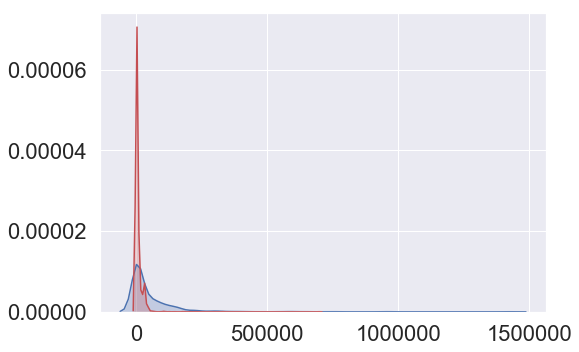

In [7]:
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=2)
pd.set_option('display.max_columns', 500)

sns.kdeplot(df.len[df.label == 1].values, color="b", shade=True)
#黑样本
sns.kdeplot(df.len[df.label == 0].values, color="r", shade=True)
#白样本

In [8]:
import math
#信息熵
def getfileshan(x):
    length = 0
    word = {}
    p = 0
    sum = 0
    with open(x,'r',encoding='ISO-8859-1') as f:
        content = f.readlines()
        for i in content:
            for j in i:
                if j != '\n' and j != ' ':
                    if j not in word.keys():
                        word[j] = 1
                    else:
                        word[j] = word[j] + 1
                else:
                    pass
        f.close()
    for i in word.keys():
        sum = sum + word[i]
    for i in word.keys():
        p = p - float(word[i])/sum * math.log(float(word[i])/sum,2)
    return p

df['shang'] = df['file'].map(lambda x:getfileshan(x)).astype(float)

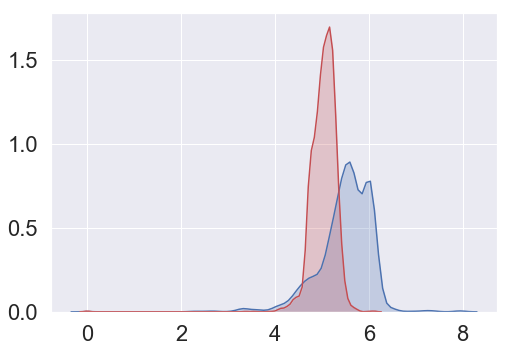

In [9]:
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=2)
pd.set_option('display.max_columns', 500)

sns.kdeplot(df.shang[df.label == 1].values, color="b", shade=True)
#黑样本
sns.kdeplot(df.shang[df.label == 0].values, color="r", shade=True)
#白样本

In [12]:
#包含的特殊函数
import re
def getfilefunc(x):
    content = ''
    content_list = []
    with open(x,'r',encoding='ISO-8859-1') as f:
        c = f.readlines()
        for i in c:
            content = content + i.strip('\n')
        f.close()
    content_list = re.split(r'\(|\)|\[|\]|\{|\}|\s|\.',content)
    max_length = 0
    for i in content_list:
        if len(i) > max_length:
            max_length = len(i)
        else:
            pass
    #文件操作函数
    count_exec = 0
    count_file = 0
    count_zip = 0
    count_code = 0
    count_chr = 0
    count_re = 0
    count_other = 0
    for i in content_list:
        if 'assert' in i or 'system' in i or 'eval' in i or 'cmd_shell' in i or 'shell_exec' in i:
            count_exec = count_exec + 1
        if 'file_get_contents' in i or 'fopen' in i or 'fwrite' in i or 'readdir' in i or 'scandir' in i or 'opendir' in i or 'curl' in i:
            count_file = count_file + 1
        if 'base64_encode' in i or 'base64_decode' in i:
            count_code = count_code + 1
        if 'gzcompress' in i or 'gzuncompress' in i or 'gzinflate' in i or 'gzdecode' in i:
            count_zip = count_zip + 1
        if 'chr' in i or 'ord' in i:
            count_chr + count_chr + 1
        if 'str_replace' in i or 'preg_replace' in i or 'substr' in i:
            count_re = count_re + 1
        if 'create_function' in i or 'pack' in i:
            count_other = count_other + 1
    #print(x)
    return (max_length,count_exec,count_file,count_zip,count_code,count_chr,count_re,count_other)
df['func'] = df['file'].map(lambda x:getfilefunc(x)).astype(list)

In [13]:
df['maxlen'] = df['func'].map(lambda x:x[0])
df['exec'] = df['func'].map(lambda x:x[1])
df['file'] = df['func'].map(lambda x:x[2])
df['zip'] = df['func'].map(lambda x:x[3])
df['code'] = df['func'].map(lambda x:x[4])
df['chr'] = df['func'].map(lambda x:x[5])
df['re'] = df['func'].map(lambda x:x[6])
df['other'] = df['func'].map(lambda x:x[7])

In [14]:
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.linear_model.logistic import LogisticRegression

In [15]:
scaler = preprocessing.StandardScaler()

len_scale_param = scaler.fit(df['len'].values.reshape(-1,1))
df['len_scaled'] = scaler.fit_transform(df['len'].values.reshape(-1,1),len_scale_param)

In [16]:
train_pre = df.filter(regex = 'label|len_scaled|shan_sclaed|maxlen_sclaed|exec_sclaed|zip_sclaed|code_sclaed')
train_pre = shuffle(train_pre)#随机排列

In [17]:
train_pre =train_pre.as_matrix()

In [18]:
train_target = train_pre[0:5000,0]
train_data = train_pre[0:5000,1:]
test_target = train_pre[5000:,0]
test_data = train_pre[5000:,1:]

In [39]:
lr = LogisticRegression().fit(x_train,y_train)
print ('training finished')
model = lr.predict(x_test)

from sklearn import metrics
from sklearn.metrics import accuracy_score
accuracy_score(model,y_test)

now training
training finished


0.6821457165732586

In [19]:
from sklearn import tree
import sklearn.ensemble as ek
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [20]:
model = { "DecisionTree    ":tree.DecisionTreeClassifier(max_depth=10),
         "RandomForest     ":ek.RandomForestClassifier(n_estimators=10,max_depth=2),
         "Adaboost         ":ek.AdaBoostClassifier(n_estimators=50),
         "GradientBoosting ":ek.GradientBoostingClassifier(n_estimators=50),
         "GNB              ":GaussianNB(),
         "LogisticRegression":LogisticRegression()   
}

In [26]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
print("算法        \t score_test    \t score_train    \t 精确率  \t  召回率 ")
#print("算法        \t score_test    \t score_train    \t 精确率  \t  召回率 ")
for algo in model:
    clf = model[algo]
    clf.fit(train_data,train_target)
    score_test = clf.score(test_data,test_target)
    score_train = clf.score(train_data,train_target)
   
    y_pred=clf.predict(test_data)#预测
    precision=metrics.precision_score(y_true=test_target,y_pred=y_pred)
    recall=metrics.recall_score(y_true=test_target,y_pred=y_pred)
    confusion=metrics.confusion_matrix(y_true=test_target,y_pred=y_pred)
    #joblib.dump(clf, './data/'+algo+'.model')
    #print(("%s \t %.6s \t %.6s \t %.6s  %s \n")%(algo,score_test,score_train,precision,confusion))
    print(("%s \t %.6s \t %.6s \t %.6s \t %.6s  ")%(algo,score_test,score_train,precision,recall))

算法        	 score_test    	 score_train    	 精确率  	  召回率 
DecisionTree     	 0.7838 	 0.825 	 0.8056 	 0.6439  
RandomForest      	 0.7566 	 0.7516 	 0.8612 	 0.5056  
Adaboost          	 0.7646 	 0.7606 	 0.8145 	 0.5738  
GradientBoosting  	 0.7830 	 0.7846 	 0.8269 	 0.6155  
GNB               	 0.7021 	 0.6958 	 0.9642 	 0.3068  
LogisticRegression 	 0.6885 	 0.6772 	 0.7473 	 0.3977  
